In [29]:
import pandas as pd
import seaborn as sns
import pickle
from collections import Counter

# Read data

In [30]:
dts = {
'customers' : pd.read_csv('./data/olist_customers_dataset.csv'), # Needed ?
'geolocs' : pd.read_csv('./data/olist_geolocation_dataset.csv'), # Needed ?
'order_items' : pd.read_csv('./data/olist_order_items_dataset.csv'),
'payments' : pd.read_csv('./data/olist_order_payments_dataset.csv'), # Needed ? 
'reviews' : pd.read_csv('./data/olist_order_reviews_dataset.csv'), # Contient les reviews des clients, comprend notamment un score nuémrique
'orders' : pd.read_csv('./data/olist_orders_dataset.csv'), # Contient date de commande, de validation, de reception etc. 
'products' : pd.read_csv('./data/olist_products_dataset.csv'), # Eventuellement, les catégories de produits ?
'sellers' :  pd.read_csv('./data/olist_sellers_dataset.csv') # Needed ?
}

The idea : produce RFM segmentation : need last purchase, frequency of orders, and total spend + review scores

Explore csv content:

In [31]:
for k in (dts):
    print("Dataset ==> {} <==, shape : ({})".format(k, dts[k].shape))
    print(dts[k].columns)

Dataset ==> customers <==, shape : ((99441, 5))
Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')
Dataset ==> geolocs <==, shape : ((1000163, 5))
Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')
Dataset ==> order_items <==, shape : ((112650, 7))
Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')
Dataset ==> payments <==, shape : ((103886, 5))
Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')
Dataset ==> reviews <==, shape : ((99224, 7))
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')
Dataset ==> orders 

Dataset selection : 
    
    + Needed : 
        + customers (only columns customer_id, and customer_unique_id ?)
        + order_items ('order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value') ??? pas sur
        + payments ('order_id', 'payment_value')
        + reviews (review_score)
        + orders : needed ! contains  order_id & customer_id & order_purchase_timestamp ! (and status ?)
        
    + Not Needed:
        + geolocs
        + products ? using category later ?
        + sellers ? using them later ?

In [32]:
Counter(dts['orders'].order_status) # Remove unavailable ?

Counter({'delivered': 96478,
         'invoiced': 314,
         'shipped': 1107,
         'processing': 301,
         'unavailable': 609,
         'canceled': 625,
         'created': 5,
         'approved': 2})

# Data Processing

## Features selection and tables joining

### Customers & Orders

Allows to produce the Recence & Frequence of RFM

In [33]:
# Keep only some columns in 'orders' (order_status : to keep only delivered orders, and the approval date - to compute recence)
dts['orders'] = dts['orders'].loc[:, ['order_id', 'customer_id', 'order_status', 'order_approved_at']]

# Idem, on 'customers'
dts['customers'] = dts['customers'].loc[:,['customer_id', 'customer_unique_id']]

Check whether all customers id are represented in both :

In [34]:
set(dts['orders'].customer_id)^set(dts['customers'].customer_id) # ok

set()

In [35]:
# Join on 'customer_id'
full_dt = dts['orders'].merge(dts['customers'], on = ['customer_id'])
full_dt

,order_id,customer_id,order_status,order_approved_at,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6
...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c


In [36]:
# Check whether we have indeed ca. 3% of customers with more than one order
customers_ids = full_dt.groupby('customer_unique_id').customer_unique_id
print("Percent customers with more than one order : {:.2f} %".format(100*sum(customers_ids.count() > 1) / len(customers_ids.count()) )) # ok.

Percent customers with more than one order : 3.12 %


### Add payments

To produce the Montant of RFM

In [37]:
# Might have several payments for on order - let's check
Counter(dts['payments'].order_id).most_common()[:5]

[('fa65dad1b0e818e3ccc5cb0e39231352', 29),
 ('ccf804e764ed5650cd8759557269dc13', 26),
 ('285c2e15bebd4ac83635ccc563dc71f4', 22),
 ('895ab968e7bb0d5659d16cd74cd1650c', 21),
 ('ee9ca989fc93ba09a6eddc250ce01742', 19)]

In [38]:
# Check correspondance from order_items table & paymments table
print(sum(dts['payments'][dts['payments'].order_id == '895ab968e7bb0d5659d16cd74cd1650c' ].payment_value))
dts['order_items'][dts['order_items'].order_id == '895ab968e7bb0d5659d16cd74cd1650c' ]

161.32000000000002


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
60265,895ab968e7bb0d5659d16cd74cd1650c,1,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21
60266,895ab968e7bb0d5659d16cd74cd1650c,2,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21
60267,895ab968e7bb0d5659d16cd74cd1650c,3,5ddab10d5e0a23acb99acf56b62b3276,3d0cd21d41671c46f82cd11176bf7277,2017-08-14 20:43:31,83.80,5.12


We can directly use the payment table to have money spend on each order by client ! No need for detailled order_items table. (i.e. sum(payments) for one order = sum(price + freight_value over products of that order)

Some payments are done in several time, let's compute the total for each order.

In [39]:
payments_ = dts['payments'].loc[:,['order_id', 'payment_value']] 
payments_ = payments_.groupby('order_id').payment_value.sum().reset_index()

Check correspondances between order_id in full_dt vs. order_id in payments_ table

In [40]:
print('=> Payments - Full')
print(len(set(payments_.order_id)-set(full_dt.order_id)))
print('=> Full - Payments')
print(len(set(full_dt.order_id)-set(payments_.order_id)))

=> Payments - Full
0
=> Full - Payments
1


One order has no associated payment ! 

Let's try with order_items instead then !

In [41]:
dts['order_items']['total_price'] = dts['order_items'].price + dts['order_items'].freight_value 
order_items_ = dts['order_items'].groupby('order_id').total_price.sum().reset_index()

In [42]:
print('=> Order Items - Full')
print(len(set(order_items_.order_id)-set(full_dt.order_id)))
print('=> Full - Order Items')
print(len(set(full_dt.order_id)-set(order_items_.order_id)))

=> Order Items - Full
0
=> Full - Order Items
775


Alright, even worst ! 775 missing from order_items !

Let's consider 'payments' then, and therefor, remove the missing order_id (by default, merge() does a inner join)

In [43]:
full_dt = full_dt.merge(payments_)
full_dt

,order_id,customer_id,order_status,order_approved_at,customer_unique_id,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,28.62
...,...,...,...,...,...,...
99435,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,85.08
99436,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,195.00
99437,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,271.01
99438,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,441.16


### Add review score

We are now going to add the review score to orders

In [44]:
# Are the review score unique by order_id ?
print(Counter(dts['reviews'].order_id).most_common(5)) # no

# Checking what's happen
dts['reviews'][dts['reviews'].order_id == '03c939fd7fd3b38f8485a0f95798f1f6']

[('c88b1d1b157a9999ce368f218a407141', 3), ('df56136b8031ecd28e200bb18e6ddb2e', 3), ('03c939fd7fd3b38f8485a0f95798f1f6', 3), ('8e17072ec97ce29f0e1f111e598b0c85', 3), ('cf73e2cb1f4a9480ed70c154da3d954a', 2)]


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
8273,b04ed893318da5b863e878cd3d0511df,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Um ponto negativo que achei foi a cobrança de ...,2018-03-20 00:00:00,2018-03-21 02:28:23
51527,f4bb9d6dd4fb6dcc2298f0e7b17b8e1e,03c939fd7fd3b38f8485a0f95798f1f6,4,NaN,NaN,2018-03-29 00:00:00,2018-03-30 00:29:09
69438,405eb2ea45e1dbe2662541ae5b47e2aa,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,Seria ótimo se tivesem entregue os 3 (três) pe...,2018-03-06 00:00:00,2018-03-06 19:50:32


In [45]:
dts['reviews'][dts['reviews'].order_id == '03c939fd7fd3b38f8485a0f95798f1f6'].review_comment_message.iloc[2]

'Seria ótimo se tivesem entregue os 3 (três) pedidos de uma única vez.'

Sometimes, multiple reviews for one order ... let's see

In [46]:
dts['order_items'][dts['order_items'].order_id == '03c939fd7fd3b38f8485a0f95798f1f6']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,total_price
1645,03c939fd7fd3b38f8485a0f95798f1f6,1,ab5da1daa941470d14366f4e76a99dd2,d91fb3b7d041e83b64a00a3edfb37e4f,2018-03-02 09:35:46,26.0,16.11,42.11


In [47]:
payments_[payments_.order_id == '03c939fd7fd3b38f8485a0f95798f1f6']

,order_id,payment_value
1469,03c939fd7fd3b38f8485a0f95798f1f6,42.11


Weird - not that there are multiple items... (but it's what customer said !). Let's say we use the mean of the score in such cases

In [48]:
reviews_ = dts['reviews'].groupby('order_id').review_score.mean().reset_index()
# No NaN - great
Counter(reviews_.review_score)

Counter({5.0: 56955,
         4.0: 19018,
         1.0: 11316,
         3.0: 8136,
         2.0: 3125,
         4.5: 54,
         3.3333333333333335: 1,
         2.5: 34,
         3.5: 25,
         1.5: 8,
         4.333333333333333: 1})

In [49]:
print('=> Reviews - Full')
print(len(set(reviews_.order_id)-set(full_dt.order_id)))
print('=> Full - Reviews')
print(len(set(full_dt.order_id)-set(reviews_.order_id)))

=> Reviews - Full
1
=> Full - Reviews
768


Well, one reviews not associated with a known order, and 768 orders without reviews ! (let's use a left join on full_dt - and set to NaN cases without review)

In [50]:
full_dt = full_dt.merge(reviews_, how = 'left')

In [51]:
full_dt

,order_id,customer_id,order_status,order_approved_at,customer_unique_id,payment_value,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,38.71,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,141.46,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,179.12,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,72.20,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,28.62,5.0
...,...,...,...,...,...,...,...
99435,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,85.08,5.0
99436,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,195.00,4.0
99437,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,271.01,5.0
99438,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,441.16,2.0


## New features computation (RFM)

In [52]:
full_dt = full_dt.loc[:, ['customer_unique_id', 'order_approved_at', 'payment_value', 'review_score', 'order_status'] ]
full_dt

,customer_unique_id,order_approved_at,payment_value,review_score,order_status
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 11:07:15,38.71,4.0,delivered
1,af07308b275d755c9edb36a90c618231,2018-07-26 03:24:27,141.46,4.0,delivered
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:55:23,179.12,5.0,delivered
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:45:59,72.20,5.0,delivered
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 22:20:29,28.62,5.0,delivered
...,...,...,...,...,...
99435,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09 09:54:05,85.08,5.0,delivered
99436,da62f9e57a76d978d02ab5362c509660,2018-02-06 13:10:37,195.00,4.0,delivered
99437,737520a9aad80b3fbbdad19b66b37b30,2017-08-27 15:04:16,271.01,5.0,delivered
99438,5097a5312c8b157bb7be58ae360ef43c,2018-01-08 21:36:21,441.16,2.0,delivered


In [53]:
# Keep only delivered orders (?)
full_dt = full_dt[full_dt.order_status == 'delivered']

In [54]:
# We sometimes, do not have date for the order (at least, date for order_approved - should check the other ?)
print(sum(full_dt.order_approved_at.isna()))

# Kick them out
full_dt = full_dt[~full_dt.order_approved_at.isna()]

14


### Convert date (str) to date

In [55]:
from datetime import datetime, date, timedelta
full_dt.order_approved_at = full_dt.order_approved_at.apply(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())

In [56]:
full_dt

,customer_unique_id,order_approved_at,payment_value,review_score,order_status
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,38.71,4.0,delivered
1,af07308b275d755c9edb36a90c618231,2018-07-26,141.46,4.0,delivered
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,179.12,5.0,delivered
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18,72.20,5.0,delivered
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,28.62,5.0,delivered
...,...,...,...,...,...
99435,6359f309b166b0196dbf7ad2ac62bb5a,2017-03-09,85.08,5.0,delivered
99436,da62f9e57a76d978d02ab5362c509660,2018-02-06,195.00,4.0,delivered
99437,737520a9aad80b3fbbdad19b66b37b30,2017-08-27,271.01,5.0,delivered
99438,5097a5312c8b157bb7be58ae360ef43c,2018-01-08,441.16,2.0,delivered


In [57]:
full_dt.to_csv('./data/clean_data.csv', index = False)

In [71]:
# Define function to select orders based on dates
## Either specifying a starting and endind date
## Either specifying and end date, and number of days before 

def period_selection(dt, end, start = None, n_days = None):
    to_return = dt.copy()
    if start is None and n_days is None:
        raise ValueError("Starting date, or duration (n_days) must be given")
    else:
        if start is None :
            start = end - timedelta(days = n_days) 
    
    print("Start : {}, end : {}".format(start, end))

    to_return = to_return[ (to_return.order_approved_at > start) & (to_return.order_approved_at < end) ]            
    return to_return            

# Define function to compute RFM + mean review score (rfm extended)
def rfm_ex(dt):
    
    min_date = min(dt.order_approved_at)
    max_date = max(dt.order_approved_at)
    period_length_days = (max_date - min_date).days
    
    # Get last order for each customer unique id
    recence = dt.loc[:,['customer_unique_id', 'order_approved_at'] ].\
                sort_values(by="order_approved_at").\
                drop_duplicates(subset=["customer_unique_id"], keep="last").\
                reset_index(drop=True)
    
    # Compute time since last order
    recence.loc[:,'order_approved_at'] = recence.loc[:,'order_approved_at'].apply(lambda x : (max_date - x).days )

    recence.rename(columns={"order_approved_at": "recence",}, inplace=True)
    
    # Get frequency
    frequence = dt.groupby('customer_unique_id').customer_unique_id.count() / period_length_days
    frequence = pd.DataFrame({ 'customer_unique_id' : frequence.index, 
                               'frequency' : frequence.values})
    
    # Montant (total ? mean ?)
    montant = dt.groupby('customer_unique_id').payment_value.sum() / period_length_days
    montant = pd.DataFrame({ 'customer_unique_id' : montant.index, 
                             'montant' : montant.values})
    
    # Review
    revs = dt.groupby('customer_unique_id').review_score.mean()
    revs = pd.DataFrame({ 'customer_unique_id' : revs.index, 
                          'review_score' : revs.values})
    
    rfm = recence.merge(frequence, on = 'customer_unique_id').\
                  merge(montant, on = 'customer_unique_id').\
                  merge(revs, on = 'customer_unique_id')
    return rfm


In [77]:
last_date = list(full_dt.order_approved_at.sort_values())[full_dt.shape[0]-1]
period = period_selection(full_dt, end = last_date, n_days = 700)
dt = rfm_ex(period)
dt

Start : 2016-09-28, end : 2018-08-29


,customer_unique_id,recence,frequency,montant,review_score
0,9f302d00dd3e18ed3745778184b4f0fe,693,0.001443,0.342641,5.0
1,3f4f614c632af7fc7508462a7cb55ac2,693,0.001443,0.026869,5.0
2,f176923a0a4ab546c7287791ccb82193,693,0.001443,0.146378,5.0
3,8d36e7e56a9f8044df728e9cbf5a3eaf,693,0.001443,0.460317,1.0
4,10e89fd8e5c745f81bec101207ba4d7d,693,0.001443,0.133146,1.0
...,...,...,...,...,...
93326,c68b545a924d24da9c0f35ab7e6aee94,0,0.001443,0.038066,5.0
93327,faa906cd93e9c6017fc5e6f885f3a05c,0,0.001443,0.126681,5.0
93328,dad1eb1624d037f15eeac6c2c2cd0843,0,0.001443,0.118528,2.0
93329,6d2ca69d13c11fd702133bfc8a1310a3,0,0.001443,0.161068,5.0


### Plot RFM

In [78]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

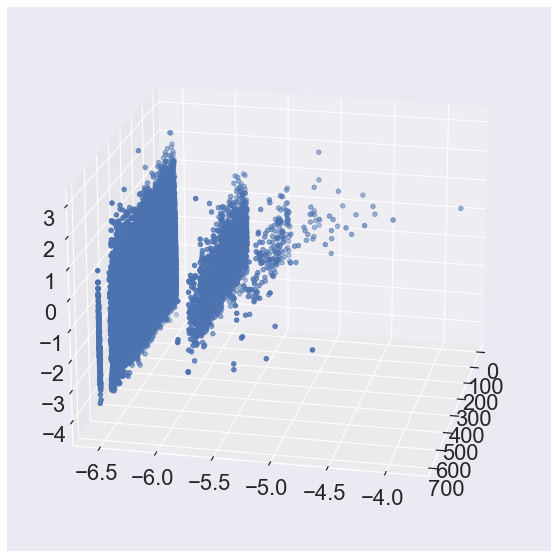

In [112]:
# %matplotlib notebook # to run on Jupyter Notebook to be interactive ! 
sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(dt.recence, np.log(dt.frequency), np.log(dt.montant),  );
ax.view_init(elev=20, azim=12)

In [84]:
dt.corr()

,recence,frequency,montant,review_score
recence,1.000000,-0.022087,-0.004463,-0.007734
frequency,-0.022087,1.000000,0.122078,0.009103
montant,-0.004463,0.122078,1.000000,-0.040785
review_score,-0.007734,0.009103,-0.040785,1.000000


## First analysis (dimension reduction)

### PCA

In [85]:
from sklearn import preprocessing
from sklearn import decomposition

In [86]:
def display_corr_circle(pcs, ev, axis, labels, dist_threshold = 0.4, jitter = 0.08):
    d1 = axis[0]-1
    d2 = axis[1]-1
    fig, ax = plt.subplots(figsize=(7,6))

    # Could also implement cos2 quality.
    distance_subset = np.apply_along_axis(lambda x : np.sqrt(np.sum(x**2)), 1, pcs[[d1, d2],:].T) > dist_threshold
    
    # Draw arrows
    plt.quiver(np.zeros(sum(distance_subset)), np.zeros(sum(distance_subset)),
                       pcs[d1,distance_subset], pcs[d2,distance_subset], 
                       angles='xy', scale_units='xy', scale=1, color="grey")
    plt.xlim([-1.01,1.01])
    plt.ylim([-1.01,1.01])

    # Labels
    # Jittering randomly, may need several draw to get something w/o overlapping labels
    for i,(x, y) in enumerate(pcs[[d1, d2]].T):
        if distance_subset[i]:
            plt.text(x, (y + np.random.uniform(-jitter,+jitter,1)),
                     labels[i], fontsize='18', ha='left', va='center', color = 'black', alpha=0.5)

    # Circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='black')
    plt.gca().add_artist(circle)

    plt.xlabel('PC{} ({}%)'.format(axis[0], round(100*pca.explained_variance_ratio_[d1],1)))
    plt.ylabel('PC{} ({}%)'.format(axis[1], round(100*pca.explained_variance_ratio_[d2],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(d1+1, d2+1));

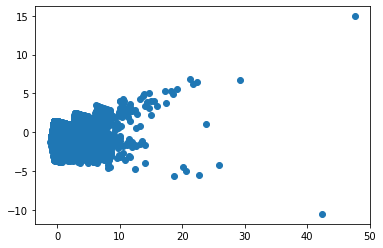

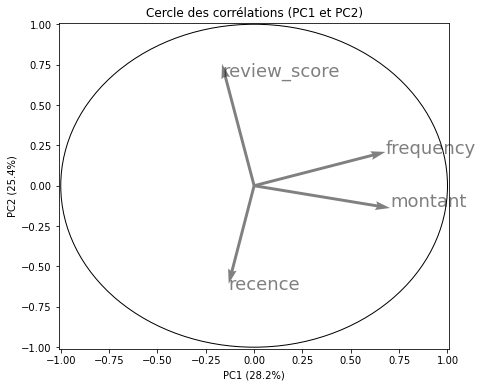

In [87]:
X_subset = dt.loc[:,['recence','frequency', 'montant']]
X_subset_scaled = preprocessing.StandardScaler().fit_transform(X_subset)

X = dt.iloc[:,1:]
X = X[~X.review_score.isna()]
X_scaled = preprocessing.StandardScaler().fit_transform(X)

pca = decomposition.PCA(n_components = 3)
pca.fit(X_scaled)

ev = pca.explained_variance_ratio_
pcs = pca.components_

X_projected = pca.transform(X_scaled)

plt.scatter(X_projected[:, 0], X_projected[:, 1])
display_corr_circle(pcs, ev, (1,2), dt.columns[1:])

### t-SNE - RFM

In [90]:
from sklearn import manifold

tsne_25 = manifold.TSNE(n_components=2, perplexity=25, init='pca')
X_subset_tsne_25 = tsne_25.fit_transform(X_subset_scaled)

tsne_50 = manifold.TSNE(n_components=2, perplexity=50, init='pca')
X_subset_tsne_50 = tsne_50.fit_transform(X_subset_scaled)

tsne_100 = manifold.TSNE(n_components=2, perplexity=100, init='pca')
X_subset_tsne_100 = tsne_100.fit_transform(X_subset_scaled)

tsne_200 = manifold.TSNE(n_components=2, perplexity=200, init='pca')
X_subset_tsne_200 = tsne_200.fit_transform(X_subset_scaled)

tsne_300 = manifold.TSNE(n_components=2, perplexity=300, init='pca')
X_subset_tsne_300 = tsne_300.fit_transform(X_subset_scaled)

C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'a

In [97]:
# Save objects - 

with open('./data/t-SNE_subset_25.pkl', 'wb') as outp:
    pickle.dump(X_subset_tsne_25, outp, pickle.HIGHEST_PROTOCOL)
    
with open('./data/t-SNE_subset_50.pkl', 'wb') as outp:
    pickle.dump(X_subset_tsne_50, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_subset_100.pkl', 'wb') as outp:
    pickle.dump(X_subset_tsne_100, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_subset_200.pkl', 'wb') as outp:
    pickle.dump(X_subset_tsne_200, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_subset_300.pkl', 'wb') as outp:
    pickle.dump(X_subset_tsne_300, outp, pickle.HIGHEST_PROTOCOL)

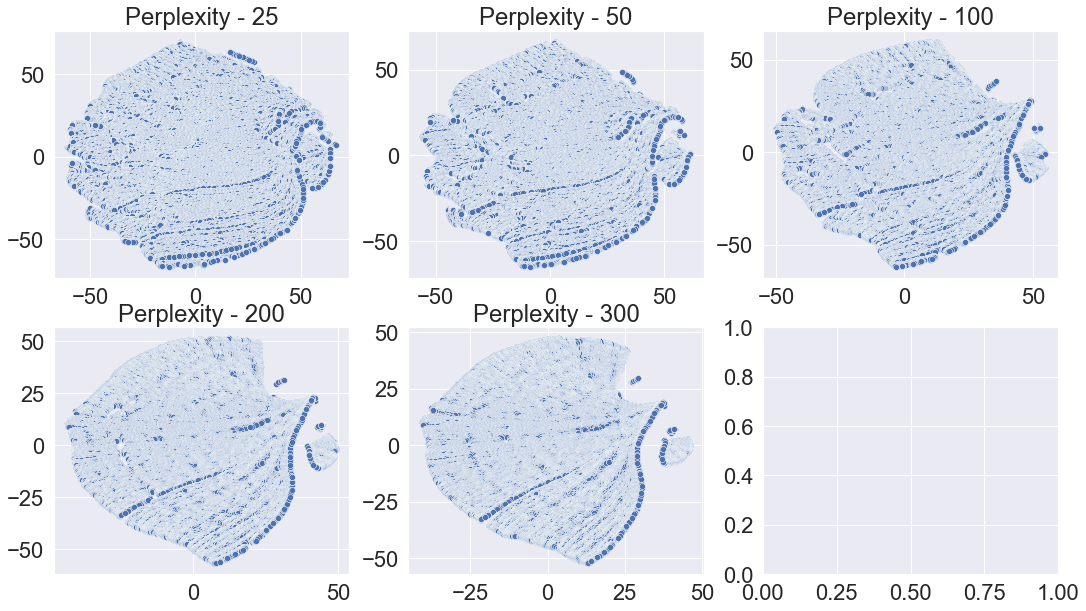

In [93]:
sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)

fig, ax = plt.subplots(2,3)

sns.scatterplot(x = X_subset_tsne_25[:, 0], y = X_subset_tsne_25[:, 1], ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_subset_tsne_50[:, 0], y = X_subset_tsne_50[:, 1], ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_subset_tsne_100[:, 0], y = X_subset_tsne_100[:, 1], ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_subset_tsne_200[:, 0], y = X_subset_tsne_200[:, 1], ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_subset_tsne_300[:, 0], y = X_subset_tsne_300[:, 1], ax=ax[1,1]).set(title='Perplexity - 300');

### t-SNE - RFMe

In [92]:
tsne_25 = manifold.TSNE(n_components=2, perplexity=25, init='pca')
X_tsne_25 = tsne_25.fit_transform(X_scaled)

tsne_50 = manifold.TSNE(n_components=2, perplexity=50, init='pca')
X_tsne_50 = tsne_50.fit_transform(X_scaled)

tsne_100 = manifold.TSNE(n_components=2, perplexity=100, init='pca')
X_tsne_100 = tsne_100.fit_transform(X_scaled)

tsne_200 = manifold.TSNE(n_components=2, perplexity=200, init='pca')
X_tsne_200 = tsne_200.fit_transform(X_scaled)

tsne_300 = manifold.TSNE(n_components=2, perplexity=300, init='pca')
X_tsne_300 = tsne_300.fit_transform(X_scaled)

C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\max\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'a

In [98]:
# Save objects - 

with open('./data/t-SNE_25.pkl', 'wb') as outp:
    pickle.dump(X_tsne_25, outp, pickle.HIGHEST_PROTOCOL)
    
with open('./data/t-SNE_50.pkl', 'wb') as outp:
    pickle.dump(X_tsne_50, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_100.pkl', 'wb') as outp:
    pickle.dump(X_tsne_100, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_200.pkl', 'wb') as outp:
    pickle.dump(X_tsne_200, outp, pickle.HIGHEST_PROTOCOL)
        
with open('./data/t-SNE_300.pkl', 'wb') as outp:
    pickle.dump(X_tsne_300, outp, pickle.HIGHEST_PROTOCOL)

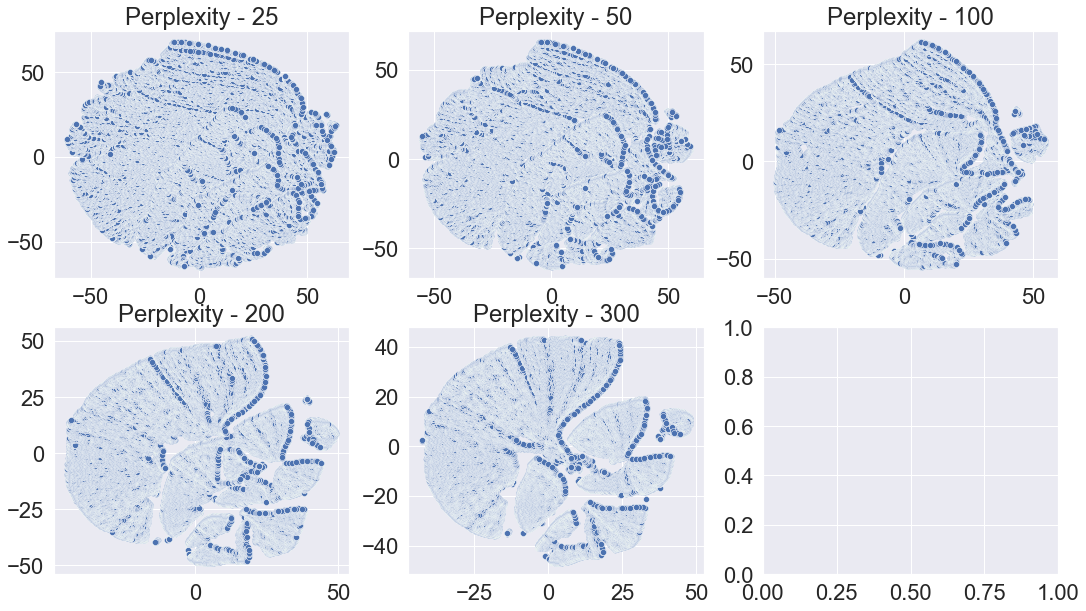

In [99]:
sns.set(rc = {'figure.figsize':(18,10)}, font_scale = 2)

fig, ax = plt.subplots(2,3)

sns.scatterplot(x = X_tsne_25[:, 0], y = X_tsne_25[:, 1], ax=ax[0,0]).set(title='Perplexity - 25');
sns.scatterplot(x = X_tsne_50[:, 0], y = X_tsne_50[:, 1], ax=ax[0,1]).set(title='Perplexity - 50');
sns.scatterplot(x = X_tsne_100[:, 0], y = X_tsne_100[:, 1], ax=ax[0,2]).set(title='Perplexity - 100');

sns.scatterplot(x = X_tsne_200[:, 0], y = X_tsne_200[:, 1], ax=ax[1,0]).set(title='Perplexity - 200');
sns.scatterplot(x = X_tsne_300[:, 0], y = X_tsne_300[:, 1], ax=ax[1,1]).set(title='Perplexity - 300');

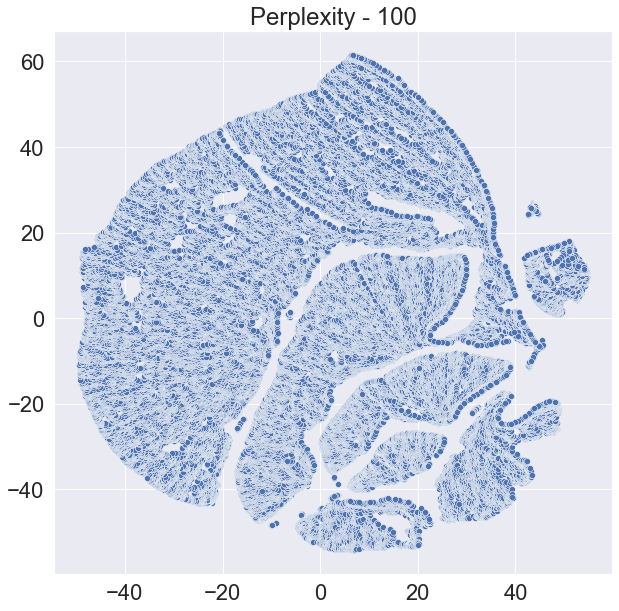

In [117]:
sns.set(rc = {'figure.figsize':(10,10)}, font_scale = 2)

sns.scatterplot(x = X_tsne_100[:, 0], y = X_tsne_100[:, 1]).set(title='Perplexity - 100');